In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
sns.set(style="whitegrid")

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


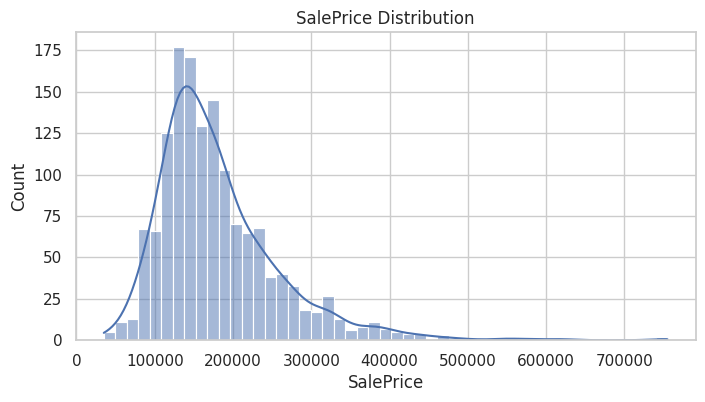

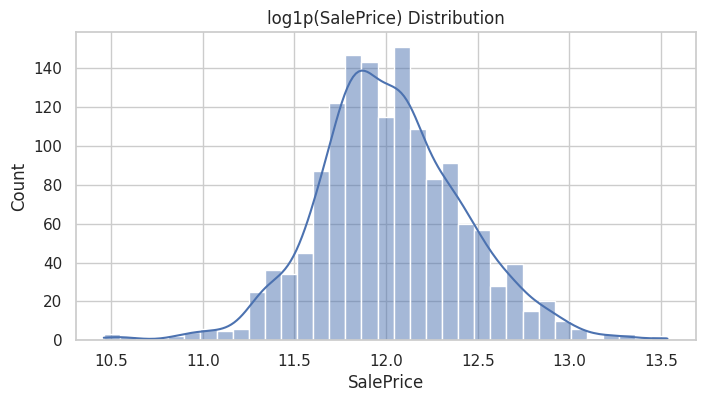

In [5]:
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing>0].head(20)
plt.figure(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(train['SalePrice']), kde=True)
plt.title('log1p(SalePrice) Distribution')
plt.show()

In [6]:
baseline_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', 'GarageCars', 'YearBuilt']
X = train[baseline_features]
X_test = test[baseline_features]
y = train['SalePrice']
print("X shape:", X.shape)
print("First few rows:")
display(X.head())

X shape: (1460, 6)
First few rows:


,OverallQual,GrLivArea,TotalBsmtSF,FullBath,GarageCars,YearBuilt
0,7,1710,856,2,2,2003
1,6,1262,1262,2,2,1976
2,7,1786,920,2,2,2001
3,7,1717,756,1,3,1915
4,8,2198,1145,2,3,2000


In [7]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
scores = cross_val_score(lr, X, np.log1p(y), scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)
print("Linear Regression CV RMSEs (log1p target):", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

Linear Regression CV RMSEs (log1p target): [0.15835289 0.18569247 0.16903054 0.15633258 0.21265014]
Mean RMSE: 0.17641172311747133


In [8]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
scores_rf = cross_val_score(rf, X, np.log1p(y), scoring='neg_mean_squared_error', cv=5)
rmse_rf = np.sqrt(-scores_rf)
print("Random Forest CV RMSEs (log1p target):", rmse_rf)
print("Mean RMSE:", rmse_rf.mean())

Random Forest CV RMSEs (log1p target): [0.17200459 0.18029243 0.16592788 0.14543468 0.16387143]
Mean RMSE: 0.16550620120227758


In [9]:
train_df = train.copy()
test_df = test.copy()
train_ID = train_df['Id']
test_ID = test_df['Id']
y = train_df['SalePrice']
train_df.drop(['SalePrice','Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)
all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print("Combined shape:", all_df.shape)
all_df['TotalSF'] = all_df[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].fillna(0).sum(axis=1)
all_df['HouseAge'] = all_df['YrSold'] - all_df['YearBuilt']
all_df['HasPool'] = (all_df['PoolArea'] > 0).astype(int)
numeric_cols = all_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if all_df[col].isnull().sum() > 0:
        all_df[col] = all_df[col].fillna(all_df[col].median())
cat_cols = all_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if all_df[col].isnull().sum() > 0:
        all_df[col] = all_df[col].fillna('None')
print("Missing values handled")
all_df = pd.get_dummies(all_df, drop_first=True)
print("After one-hot encoding, shape =", all_df.shape)
n_train = train.shape[0]
X_train = all_df.iloc[:n_train, :].copy()
X_test = all_df.iloc[n_train:, :].copy().reset_index(drop=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
print("Final X_train shape:", X_train.shape)

Combined shape: (2919, 79)
Missing values handled
After one-hot encoding, shape = (2919, 270)
Final X_train shape: (1460, 270)


In [10]:
from sklearn.ensemble import RandomForestRegressor
rf_full = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
scores_rf_full = cross_val_score(rf_full, X_train, np.log1p(y), scoring='neg_mean_squared_error', cv=5)
rmse_rf_full = np.sqrt(-scores_rf_full)
print("Random Forest (full features) CV RMSEs (log1p target):", rmse_rf_full)
print("Mean RMSE:", rmse_rf_full.mean())

Random Forest (full features) CV RMSEs (log1p target): [0.1374403  0.15568322 0.14644288 0.13193728 0.14955339]
Mean RMSE: 0.14421141582273775


In [11]:
final_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
final_model.fit(X_train, np.log1p(y))
preds_log = final_model.predict(X_test)
preds = np.expm1(preds_log)
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': preds})
submission.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'")

Submission saved as 'submission.csv'


In [12]:
import joblib
joblib.dump(final_model, 'final_model_rf.joblib')
print("Model saved as 'final_model_rf.joblib'")

Model saved as 'final_model_rf.joblib'


In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
rf_tune = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)
rf_random.fit(X_train, np.log1p(y))
print("Best parameters:", rf_random.best_params_)
best_rmse = np.sqrt(-rf_random.best_score_)
print("Best CV RMSE (log1p):", best_rmse)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=

In [15]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                        max_depth=5, subsample=0.8, colsample_bytree=0.8,
                        random_state=42, n_jobs=-1)
scores_xgb = cross_val_score(xgbr, X_train, np.log1p(y), scoring='neg_mean_squared_error', cv=5)
rmse_xgb = np.sqrt(-scores_xgb)
print("XGBoost CV RMSEs:", rmse_xgb)
print("Mean RMSE:", rmse_xgb.mean())

XGBoost CV RMSEs: [0.11669861 0.13941761 0.13321031 0.11340088 0.12625623]
Mean RMSE: 0.12579672804301406


In [16]:
final_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                             max_depth=5, subsample=0.8, colsample_bytree=0.8,
                             random_state=42, n_jobs=-1)
final_xgb.fit(X_train, np.log1p(y))
preds_log = final_xgb.predict(X_test)
preds = np.expm1(preds_log)
submission = pd.DataFrame({'Id': test_ID, 'SalePrice': preds})
submission.to_csv('submission_xgb.csv', index=False)
print("Submission saved as 'submission_xgb.csv'")

Submission saved as 'submission_xgb.csv'


In [17]:
import joblib
joblib.dump(final_xgb, 'final_model_xgb.joblib')
print("XGBoost model saved as 'final_model_xgb.joblib'")

XGBoost model saved as 'final_model_xgb.joblib'


In [18]:
from sklearn.ensemble import RandomForestRegressor
rf_ensemble = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_ensemble.fit(X_train, np.log1p(y))
xgb_ensemble = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                                max_depth=5, subsample=0.8, colsample_bytree=0.8,
                                random_state=42, n_jobs=-1)
xgb_ensemble.fit(X_train, np.log1p(y))
rf_preds_log = rf_ensemble.predict(X_test)
xgb_preds_log = xgb_ensemble.predict(X_test)
stacked_preds_log = (rf_preds_log + xgb_preds_log) / 2
stacked_preds = np.expm1(stacked_preds_log)
submission_stack = pd.DataFrame({'Id': test_ID, 'SalePrice': stacked_preds})
submission_stack.to_csv('submission_stack.csv', index=False)
print("Stacked submission saved as 'submission_stack.csv'")

Stacked submission saved as 'submission_stack.csv'


In [19]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_rf = np.zeros(len(X_train))
oof_xgb = np.zeros(len(X_train))
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = np.log1p(y.iloc[train_idx]), np.log1p(y.iloc[val_idx])
    rf_fold = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    rf_fold.fit(X_tr, y_tr)
    oof_rf[val_idx] = rf_fold.predict(X_val)
    xgb_fold = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                                max_depth=5, subsample=0.8, colsample_bytree=0.8,
                                random_state=42, n_jobs=-1)
    xgb_fold.fit(X_tr, y_tr)
    oof_xgb[val_idx] = xgb_fold.predict(X_val)

print("Out-of-fold predictions ready for meta-model")
meta_X = np.column_stack([oof_rf, oof_xgb])
meta_y = np.log1p(y)
meta_model = LinearRegression()
meta_model.fit(meta_X, meta_y)
print("Meta-model trained (Linear Regression)")
rf_final = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_final.fit(X_train, np.log1p(y))
rf_test_pred = rf_final.predict(X_test)
xgb_final = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                             max_depth=5, subsample=0.8, colsample_bytree=0.8,
                             random_state=42, n_jobs=-1)
xgb_final.fit(X_train, np.log1p(y))
xgb_test_pred = xgb_final.predict(X_test)
meta_test_X = np.column_stack([rf_test_pred, xgb_test_pred])
stacked_meta_preds_log = meta_model.predict(meta_test_X)
stacked_meta_preds = np.expm1(stacked_meta_preds_log)
submission_meta = pd.DataFrame({'Id': test_ID, 'SalePrice': stacked_meta_preds})
submission_meta.to_csv('submission_meta_stack.csv', index=False)
print("Stacked submission with meta-model saved as 'submission_meta_stack.csv'")

Out-of-fold predictions ready for meta-model
Meta-model trained (Linear Regression)
Stacked submission with meta-model saved as 'submission_meta_stack.csv'


In [20]:
rf_final = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_final.fit(X_train, np.log1p(y))
rf_preds_log = rf_final.predict(X_test)
xgb_final = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                             max_depth=5, subsample=0.8, colsample_bytree=0.8,
                             random_state=42, n_jobs=-1)
xgb_final.fit(X_train, np.log1p(y))
xgb_preds_log = xgb_final.predict(X_test)
stacked_weighted_log = 0.3 * rf_preds_log + 0.7 * xgb_preds_log
stacked_weighted_preds = np.expm1(stacked_weighted_log)
submission_weighted = pd.DataFrame({'Id': test_ID, 'SalePrice': stacked_weighted_preds})
submission_weighted.to_csv('submission_weighted_stack.csv', index=False)
print("Weighted stacked submission saved as 'submission_weighted_stack.csv'")

Weighted stacked submission saved as 'submission_weighted_stack.csv'


In [21]:
min_price, max_price = y.min(), y.max()
stacked_weighted_preds_clipped = np.clip(stacked_weighted_preds, min_price, max_price)
submission_final = pd.DataFrame({'Id': test_ID, 'SalePrice': stacked_weighted_preds_clipped})
submission_final.to_csv('submission_final.csv', index=False)
print("Final submission saved as 'submission_final.csv'")

Final submission saved as 'submission_final.csv'


In [22]:
!pip install lightgbm
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                              max_depth=7, subsample=0.8, colsample_bytree=0.8,
                              random_state=42, n_jobs=-1)
lgb_model.fit(X_train, np.log1p(y))
lgb_preds_log = lgb_model.predict(X_test)
blended_log = 0.3 * rf_preds_log + 0.5 * xgb_preds_log + 0.2 * lgb_preds_log
blended_preds = np.expm1(blended_log)
submission_blend = pd.DataFrame({'Id': test_ID, 'SalePrice': blended_preds})
submission_blend.to_csv('submission_blend.csv', index=False)
print("Blended submission saved as 'submission_blend.csv'")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 178
[LightGBM] [Info] Start training from score 12.024057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best